# XPCS Pipeline for SAXS
"This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

This notebook begins with a raw time-series of images and ends with $g_2(t)$ for a range of $q$, fit to an exponential or stretched exponential, and a two-time correlation functoin.

## Overview

* Setup: load packages/setup path
* Load Metadata & Image Data
* Apply Mask
* Clean Data: shutter open/bad frames
* Get Q-Map
* Get 1D curve
* Define Q-ROI (qr, qz)
* Check beam damage
* One-time Correlation
* Fitting
* Two-time Correlation
The important scientific code is imported from the [chxanalys](https://github.com/yugangzhang/chxanalys/tree/master/chxanalys) and [scikit-beam](https://github.com/scikit-beam/scikit-beam) project. Refer to chxanalys and scikit-beam for additional documentation and citation information.

## CHX Olog NoteBook
CHX Olog (https://logbook.nsls2.bnl.gov/11-ID/)

## Setup

Import packages for I/O, visualization, and analysis.

In [1]:
from chxanalys.chx_packages import *
%matplotlib notebook
plt.rcParams.update({'figure.max_open_warning': 0})
#%reset -f  #for clean up things in the memory

/opt/conda_envs/analysis/lib/python3.5/site-packages/filestore/retrieve.py:15: UserWarning: Do not import filestore.retrieve, import filestore.api instead
  warnings.warn("Do not import filestore.retrieve, "


## Control Runs Here

In [2]:
force_compress = False #True   #force to compress data 
para_compress = True    #parallel compress
run_fit_form = False    #run fit form factor 
run_waterfall = True #False   #run waterfall analysis
run_t_ROI_Inten = True  #run  ROI intensity as a function of time
run_fit_g2 = True       #run  fit one-time, the default function is "stretched exponential"
run_two_time = True #True #False    #run  two-time
run_four_time = False   #run  four-time
run_xsvs=True           #run visibility analysis
att_pdf_report = True    #attach the pdf report to CHX olog


qth_interest = 3      #the intested single qth             
use_sqnorm = False    #if True, use sq to normalize intensity
pdf_version='_1'     #for pdf report name

## Make a directory for saving results

In [3]:
CYCLE = '2016_3'
username = getpass.getuser()
#username = "colosqui"   #provide the username to force the results to save in that username folder
data_dir0 = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')
##Or define data_dir here, e.g.,#data_dir = '/XF11ID/analysis/2016_2/rheadric/test/'
os.makedirs(data_dir0, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir0)

Results from this analysis will be stashed in the directory /XF11ID/analysis/2016_3/yuzhang/Results/


## Load Metadata & Image Data

Print detector, scan-id, uid, datapath of data collected.

# Change these lines to get data

In [45]:
start_time, stop_time = '2016-12-1  14:18:10', '2016-12-1  14:23:10' 

sids, uids = find_uids(start_time, stop_time)
uid = uids[0]

Totally 10 uids are found
b4cc2d07
3db07599
c4853e47
0ec90190
414a769b
76cc92a0
68769dd0
46f5508f
56bc2dc8
5e0ffa04


In [41]:
%run /XF11ID/analysis/Analysis_Pipelines/Develop/chxanalys/chxanalys/chx_generic_functions.py

In [46]:
check_bad_uids( uids, mask, img_choice_N = 3 )

hdf5 path = /XF11ID/data/2016/12/01/6203c28f-6e2c-4aa7-8d06_2270_master.h5
hdf5 path = /XF11ID/data/2016/12/01/1a92effa-3177-46d7-a058_2271_master.h5
The bad uid is: 56bc2dc8
hdf5 path = /XF11ID/data/2016/12/01/d68786dc-4f96-4c3b-b9d4_2272_master.h5
The bad uid is: 46f5508f
hdf5 path = /XF11ID/data/2016/12/01/f7f569f0-d506-4f41-9f81_2273_master.h5
The bad uid is: 68769dd0
hdf5 path = /XF11ID/data/2016/12/01/f8e0c97a-205d-4a0f-afd5_2274_master.h5
The bad uid is: 76cc92a0
hdf5 path = /XF11ID/data/2016/12/01/896f3d26-aa63-436a-a7db_2275_master.h5
The bad uid is: 414a769b
hdf5 path = /XF11ID/data/2016/12/01/9b2ef699-f751-4c74-b3ec_2276_master.h5
The bad uid is: 0ec90190
hdf5 path = /XF11ID/data/2016/12/01/35d12edb-1254-4e14-a44c_2277_master.h5
The bad uid is: c4853e47
hdf5 path = /XF11ID/data/2016/12/01/31e13cb2-ab12-4d53-8ccc_2278_master.h5
The bad uid is: 3db07599
hdf5 path = /XF11ID/data/2016/12/01/4e2bccd3-9cd0-4bac-885f_2279_master.h5
The bad uid is: b4cc2d07
The total and bad uids nu

['56bc2dc8',
 '46f5508f',
 '68769dd0',
 '76cc92a0',
 '414a769b',
 '0ec90190',
 'c4853e47',
 '3db07599',
 'b4cc2d07']

In [5]:
uid_=  'Au50nm_2.5perc_PEG_X2_Dec1_2016' #give a meaningful folder name  

data_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/%s/'%uid_)
os.makedirs(data_dir, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir)
data_dir_ = os.path.join( data_dir, 'Average/')
os.makedirs(data_dir_, exist_ok=True)
print ( data_dir_)

Results from this analysis will be stashed in the directory /XF11ID/analysis/2016_3/yuzhang/Results/Au50nm_2.5perc_PEG_X2_Dec1_2016/
/XF11ID/analysis/2016_3/yuzhang/Results/Au50nm_2.5perc_PEG_X2_Dec1_2016/Average/


# Don't Change these lines below here

In [6]:
md = get_meta_data( uid )

In [7]:
imgs = load_data( uid, md['detector'], reverse= True  )
md.update( imgs.md );Nimg = len(imgs);
pixel_mask =  1- np.int_( np.array( imgs.md['pixel_mask'], dtype= bool)  )
print( 'The data are: %s' %imgs )

hdf5 path = /XF11ID/data/2016/12/01/93cf649a-cc16-4af9-a1a5_2250_master.h5
The data are: Sliced and/or processed FixedEigerImages. Original repr:
    <Frames>
    Length: 200 frames
    Frame Shape: 2167 x 2070
    Pixel Datatype: uint16


## Overwrite Some Metadata Due to Wrong Input

In [8]:
dpix = md['x_pixel_size'] * 1000.  #in mm, eiger 4m is 0.075 mm
lambda_ =md['incident_wavelength']    # wavelegth of the X-rays in Angstroms
Ldet = md['detector_distance'] *1000     # detector to sample distance (mm)
try:
    exposuretime= md['cam_acquire_t']     #exposure time in sec
except:    
    exposuretime= md['count_time']     #exposure time in sec
acquisition_period = md['frame_time']   #acquisition time in sec
timeperframe = acquisition_period #for g2
center = [  int(md['beam_center_y']),int( md['beam_center_x'] ) ]  #beam center [y,x] for python image
#center = [ 2070-1381-0, 1475-4] 

In [9]:
setup_pargs=dict(uid=uid, dpix= dpix, Ldet=Ldet, lambda_= lambda_, exposuretime=exposuretime,
        timeperframe=timeperframe, center=center, path= data_dir)

In [10]:
print_dict( setup_pargs )

timeperframe--> 0.00134
center--> [816, 1443]
Ldet--> 4889.99986649
uid--> 63ca1e4a
path--> /XF11ID/analysis/2016_3/yuzhang/Results/Au50nm_2.5perc_PEG_X2_Dec1_2016/
exposuretime--> 0.0013299999991431832
lambda_--> 1.28481
dpix--> 0.0750000035623


## Apply Mask
* load and plot mask if exist 
* otherwise create a mask using Mask pipeline
* Reverse the mask in y-direction due to the coordination difference between python and Eiger software
* Reverse images in y-direction
* Apply the mask

# Change these lines

In [11]:
mask_path = '/XF11ID/analysis/2016_3/masks/'
mask_name = 'Nov28_4M_SAXS_mask.npy'
 
#mask_name = 'Dec3_4M_SAXS_mask.npy'

<IPython.core.display.Javascript object>


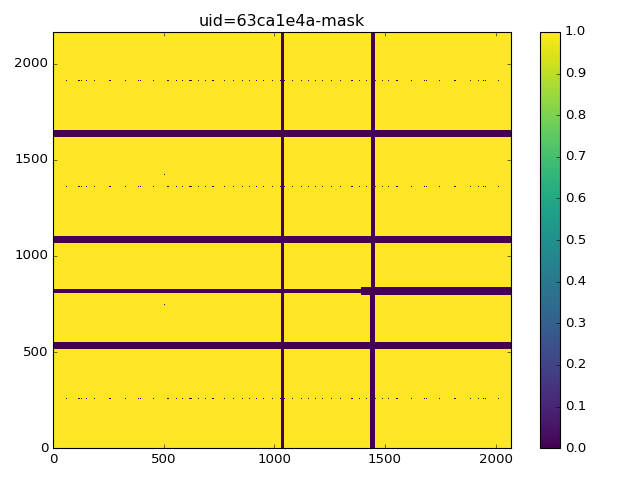

In [12]:
mask = load_mask(mask_path, mask_name, plot_ =  False, image_name = 'uid=%s-mask'%uid, reverse=True ) 
mask *= pixel_mask
mask[:,2069] =0 # False  #Concluded from the previous results
#np.save(  data_dir + 'mask', mask)
show_img(mask,image_name = 'uid=%s-mask'%uid, save=True, path=data_dir)
mask_load=mask.copy()
imgsa = apply_mask( imgs, mask )

# Save metadata into the uid folder
* save mask file
* save the metadata dict

<IPython.core.display.Javascript object>


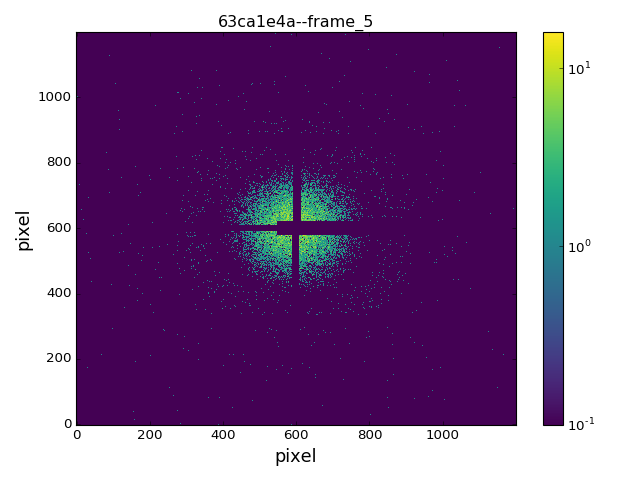

In [13]:
n= 5
avg_img =  imgsa[n] #get_avg_img( imgsa, sampling = int(Nimg/3), plot_ = False, uid =uid)
show_saxs_qmap( avg_img, setup_pargs, width=600, show_pixel = True,
               vmin=.1, vmax=np.max(avg_img), logs=True, image_name= uid + '--frame_%s'%n )

# Suppose we have all the parameters to define ROIs, if not use the "Single_Data" Pipeline

### Get circular average 
* Do plot and save q~iq


<IPython.core.display.Javascript object>


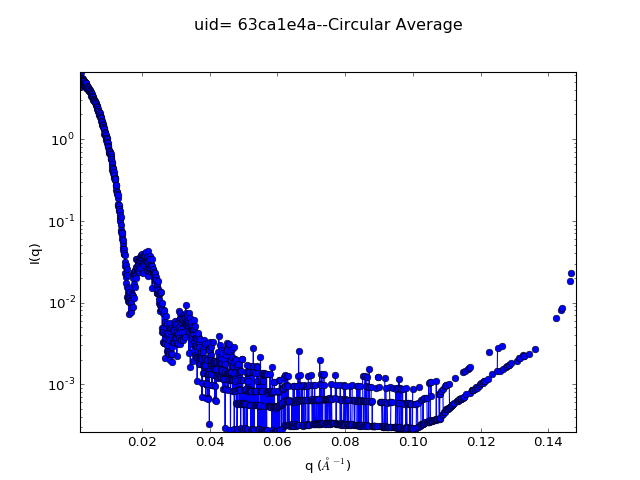

In [14]:
hmask = create_hot_pixel_mask( avg_img, threshold = 100, center=center, center_radius= 400)
qp, iq, q = get_circular_average( avg_img, mask * hmask, pargs=setup_pargs  )
plot_circular_average( qp, iq, q,  pargs=setup_pargs, 
                      xlim=[q.min(), q.max()], ylim = [iq.min(), iq.max()] )



### Define ROI
* Create ring mask defined by  inner_radius, outer_radius, width, num_rings (all in pixel unit)
* Create ring mask defined by  edges (all in pixel unit)

In [15]:
uniformq = True #False

### Define a non-uniform distributed rings by giving edges

In [16]:
if not uniformq:    
    width = 0.0002    
    number_rings= 1    
    qcenters = [ 0.00235,0.00379,0.00508,0.00636,0.00773, 0.00902] #in A-1
    edges = get_non_uniform_edges(  qcenters, width, number_rings )    
    inner_radius= None
    outer_radius = None
    width = None
    num_rings = None

### Define a uniform distributed rings by giving inner_radius, outer_radius, width, num_rings (all in pixel unit)

In [17]:
if uniformq:    
    inner_radius= 0.005 #0.005 for 50 nm, 0.006, #for 10nm/coralpor
    outer_radius = 0.04 #0.04 for 50 nm, 0.05, #for 10nm/coralpor 
    num_rings = 12
    gap_ring_number = 6
    width =    ( outer_radius - inner_radius)/(num_rings + gap_ring_number)
    edges = None

In [18]:
ring_mask, q_ring_center, q_ring_val = get_ring_mask(  mask, inner_radius=inner_radius, 
        outer_radius = outer_radius , width = width, num_rings = num_rings, edges=edges,
                      unit='A',       pargs=setup_pargs   )
qind, pixelist = roi.extract_label_indices(  ring_mask  ) 
q_ring_center = np.round( q_ring_center, 4)

<IPython.core.display.Javascript object>


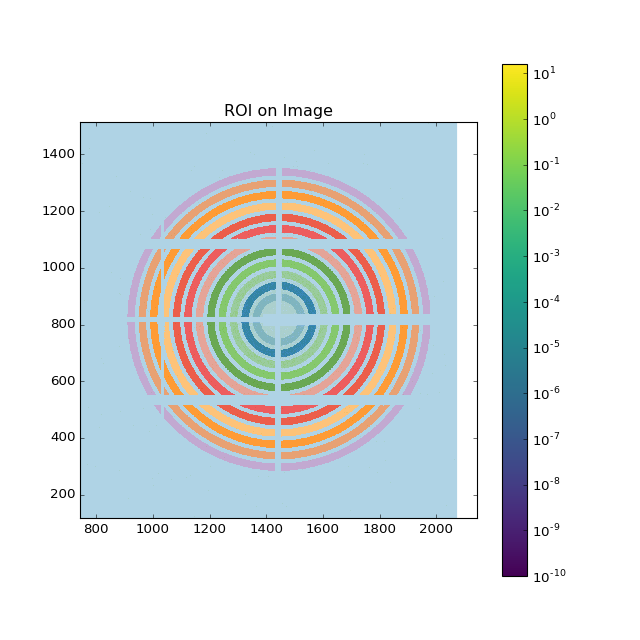

In [19]:
show_ROI_on_image( avg_img, ring_mask, center, label_on = False, rwidth =700, alpha=.9,  
                 save=True, path=data_dir, uid=uid, vmin= np.min(avg_img), vmax= np.max(avg_img) ) 

<IPython.core.display.Javascript object>


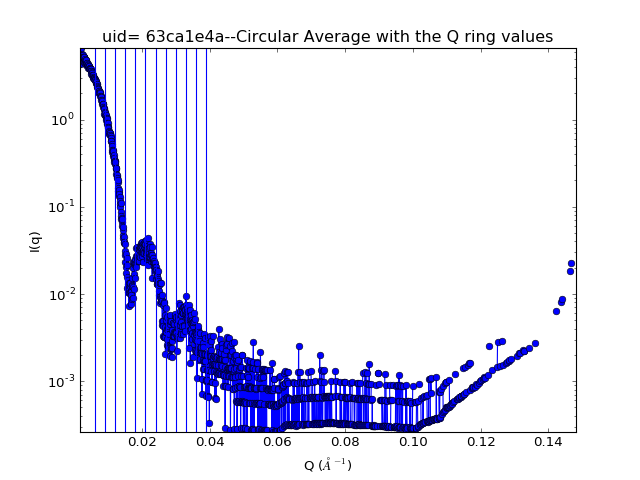

In [20]:
plot_qIq_with_ROI( q, iq, q_ring_center, logs=True, uid=uid, xlim=[q.min(), q.max()],
                  ylim = [iq.min(), iq.max()],  save=True, path=data_dir)

# Do loop here

In [21]:
run_num = 1
sub_num = len(uids)
print( run_num, sub_num)

1 10


## Control Runs Here

In [23]:
run_pargs=  dict(   
    force_compress =  True,#False,    #force to compress data 
    para_compress = True,             #parallel compress
    run_fit_form = False,             #run fit form factor  
    run_waterfall = True,             #run waterfall analysis
    run_t_ROI_Inten = True,          #run  ROI intensity as a function of time
    run_one_time = True,#False,      #run  one-time
    run_fit_g2 = True,      #run  fit one-time, the default function is "stretched exponential"
    run_two_time = True,#False,    #run  two-time
    run_four_time = False,     #run  four-time
    run_xsvs=True,            #run visibility analysis
    att_pdf_report = True,       #attach the pdf report to CHX olog
    show_plot = False,
                 
    CYCLE =  CYCLE, mask_path =  mask_path, mask_name =    mask_name, 
    good_start   =  5,
    uniformq = uniformq,    inner_radius= inner_radius, 
    outer_radius =   outer_radius,    num_rings =num_rings,   gap_ring_number = gap_ring_number, 
    #number_rings= number_rings,    
    qth_interest =  qth_interest, #the intested single qth,            
    use_sqnorm = False,    
    pdf_version = '_1' #for pdf report name    
                )

In [31]:
run_pargs=  dict(   
    force_compress = False,    #force to compress data 
    para_compress = True,             #parallel compress
    run_fit_form = False,             #run fit form factor  
    run_waterfall = False,             #run waterfall analysis
    run_t_ROI_Inten = False,          #run  ROI intensity as a function of time
    run_one_time = False,#False,      #run  one-time
    run_fit_g2 = False,      #run  fit one-time, the default function is "stretched exponential"
    run_two_time = False,#False,    #run  two-time
    run_four_time = False,     #run  four-time
    run_xsvs=True,            #run visibility analysis
    att_pdf_report = True,       #attach the pdf report to CHX olog
    show_plot = False,
                 
    CYCLE =  CYCLE, mask_path =  mask_path, mask_name =    mask_name, 
    good_start   =  5,
    uniformq = uniformq,    inner_radius= inner_radius, 
    outer_radius =   outer_radius,    num_rings =num_rings,   gap_ring_number = gap_ring_number, 
    #number_rings= number_rings,    
    qth_interest =  qth_interest, #the intested single qth,            
    use_sqnorm = False,    
    pdf_version = '_2' #for pdf report name    
                )

In [24]:
from chxanalys.XPCS_XSVS_SAXS_Single_Func import run_xpcs_xsvs_single

In [35]:
%run /XF11ID/analysis/Analysis_Pipelines/Develop/chxanalys/chxanalys/XPCS_XSVS_SAXS_Single_Func.py

In [36]:
res = run_xpcs_xsvs_single( uid, run_pargs= run_pargs, return_res=True )

Results from this analysis will be stashed in the directory /XF11ID/analysis/2016_3/yuzhang/Results/
****************************************
*****The processing uid is: 63ca1e4a*****
****************************************
Results from this analysis will be stashed in the directory /XF11ID/analysis/2016_3/yuzhang/Results/63ca1e4a/
hdf5 path = /XF11ID/data/2016/12/01/93cf649a-cc16-4af9-a1a5_2250_master.h5
The data are: Sliced and/or processed FixedEigerImages. Original repr:
    <Frames>
    Length: 200 frames
    Frame Shape: 2167 x 2070
    Pixel Datatype: uint16
suid--> 63ca1e4a
number of images--> 200
uid--> 63ca1e4a-51a6-4266-903a-6a769386e450
scan_id--> 10417
start_time--> 2016-12-01 14:08:37
stop_time--> 2016-12-01 14:08:46
sample--> 50nm Au 2.5% PEG (X2)
Measurement--> sample X2 50nm Au in 2.5% PEG_fast_series_#0
acquire period--> 0.00135
exposure time--> 2e-05
det_distanc--> 4.89
beam_center_x--> 1443.0
beam_center_y--> 816.0
timeperframe--> 0.00134
center--> [816, 1443]
Ldet

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Averaging 198 images:   0%|          | 0/200 [00:00<?, ?it/s]

The non-zeros photon occupation is 0.012676087736780741.
Will Always DO apply compress process.
Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_63ca1e4a-51a6-4266-903a-6a769386e450.cmp.
No bad frames are involved.


Averaging 198 images: 100%|██████████| 200/200 [00:00<00:00, 552.30it/s]

The good_start frame number is: 5 


<IPython.core.display.Javascript object>

Total time: 0.01 min


/opt/conda_envs/analysis/lib/python3.5/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


<IPython.core.display.Javascript object>

The bad frame list length is: 5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Averaging 9 images: 100%|██████████| 1/1 [00:00<00:00, 730.08it/s]

[[  5   6]
 [102 103]
 [199 200]]



Averaging 397 images: 100%|██████████| 1/1 [00:00<00:00, 193.65it/s]


<IPython.core.display.Javascript object>

Get ROI intensity of each frame:   0%|          | 0/195 [00:00<?, ?it/s]

The max counts are: 22


  0%|          | 0/12 [00:00<?, ?it/s]

Starting assign the tasks...


 58%|█████▊    | 7/12 [00:00<00:00, 58.36it/s]

Starting running the tasks...


100%|██████████| 12/12 [00:01<00:00,  9.70it/s]


Histogram calculation DONE!
Total time: 0.09 min
Please give lag_steps


IndexError: too many indices for array

In [ ]:
uid

In [ ]:
md['center'] = center
md['ring_mask'] = ring_mask
md['q_ring_center']= q_ring_center
md['q_ring_val'] = q_ring_val
md['beam_center_x'] =  center[1]
md['beam_center_y']=  center[0]
md['data_dir'] = data_dir

psave_obj(  md, data_dir_ + 'uid=%s-md'%uid_ ) #save the setup parameters

In [ ]:
data_dir_

In [ ]:
g2s, taus, useful_uids  = multi_uids_saxs_xpcs_analysis(   uids, md, run_num, sub_num, fit= True, compress=True  )


## Create PDF report for each uid

In [ ]:
useful_uids

* Create multi PDF report for each uid

In [ ]:
create_multi_pdf_reports_for_uids( useful_uids, g2s, data_dir )

### Attach each g2 result to the corresponding olog entry

In [ ]:
os.environ['HTTPS_PROXY'] = 'https://proxy:8888'
os.environ['no_proxy'] = 'cs.nsls2.local,localhost,127.0.0.1'

In [ ]:
from chxanalys.chx_olog import LogEntry,Attachment, update_olog_uid, update_olog_id

In [ ]:
useful_uids[1]

In [ ]:
for key in list( useful_uids.keys()):
    for k in list( useful_uids[key]):
        uid_k = useful_uids[key][k]
        filename = data_dir + 'XPCS_Analysis_Report_for_uid=%s.pdf'%uid_k 
        atch=[  Attachment(open(filename, 'rb')) ] 
        update_olog_uid( uid=uid_k, text='Add XPCS Analysis PDF Report', attachments= atch )
        #update_olog_uid( uid=uid_, text='Add XPCS Analysis PDF Report', attachments= atch )

## Create one PDF including all uids

In [ ]:
create_one_pdf_reports_for_uids( useful_uids, g2s, data_dir, filename=uid_ )

# Do average Here

In [ ]:
g2s_average ={} # g2s[run] = g2 of each time series average

for key in list( g2s.keys()):
    g2s_average[key] = np.zeros_like( g2s[key][1])
    i=1
    for sub_key in list( g2s[key].keys() ):
        #print (g2s_average[key].shape, g2s[key][sub_key].shape  )        
        try:
            g2s_average[key] +=  g2s[key][sub_key]
            i +=1
            print( 'Run= %s--sub_run= %s-- pass'%(key, sub_key) )
            #print( 'sub= %s,Doing average here'%sub_key)
        except:            
            print( 'sub= %s,Can not Doing average here'%sub_key)
            pass
    g2s_average[key] /= i-1

# Save Data

In [ ]:
for key in list( g2s.keys()):
    res_pargs = dict(taus=taus, q_ring_center=q_ring_center,
                  path=data_dir_, uid=  uid_ + '@run--%s'%key )
    save_saxs_g2(    g2s_average[key], res_pargs )


# Plot All the g2 Data

In [ ]:
if False:
    for key in list( g2s.keys()):
        for sub_key in  list( g2s[key].keys()):
            res_pargs = dict(taus=taus, q_ring_center=q_ring_center,
                          path=data_dir_, uid=  uid_ + '@run--%s--subrun--%s'%(key, sub_key) )
            plot_saxs_g2( g2s[key][sub_key], taus,  vlim=[0.95, 1.05], res_pargs=res_pargs) 


# Plot Avergaed Data

In [ ]:
if False:
    for key in list( g2s.keys()):
        res_pargs = dict(taus=taus, q_ring_center=q_ring_center,
                          path=data_dir_, uid=  uid_ + '@run--%s'%key )
        plot_saxs_g2( g2s_average[key], taus,  vlim=[0.95, 1.05], res_pargs=res_pargs) 

# Fit Averaged Data

In [ ]:
fit = True

In [ ]:
if fit:

    for key in list( g2s.keys()):
        res_pargs = dict(taus=taus, q_ring_center=q_ring_center,
                      path=data_dir_, uid=  uid_ + '@run--%s'%key )

        fit_result = fit_saxs_g2( g2s_average[key], res_pargs, function = 'stretched',  vlim=[0.95, 1.05], 
                    fit_variables={'baseline':True, 'beta':True, 'alpha':False,'relaxation_rate':True},
                    guess_values={'baseline':1.45,'beta':0.34,'alpha':1.0,'relaxation_rate':0.1})
        
        #psave_obj( fit_result, data_dir + uid_ + '@run--%s'%key )
        
        fit_q_rate(  q_ring_center[:], fit_result['rate'][:], power_variable= False,
           uid=uid_ + '@run--%s'%key, path= data_dir_ )

        save_lists( [q_ring_center**2,fit_result['rate']], ['q2','rate'], 
                   filename= 'Q2-rate-uid=%s'%(uid_ + '@run--%s'%key), path= data_dir)

# Create a report for the avergae g2

In [ ]:
create_report = True

In [ ]:
#data_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')

In [ ]:
pdf_out_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')
filename= "XPCS_Analysis_Report_for_uid=%s-average.pdf"%uid_
print (pdf_out_dir + filename)

In [ ]:
if create_report:
    
    c= create_pdf_report(  data_dir_, uid_, pdf_out_dir,
                        filename= filename)
    page =1
    #Page one: Meta-data/Iq-Q/ROI
    c.report_header(page=page)
    c.report_meta( top=730)
    c.report_static( top=560)
    c.report_ROI( top= 300)
    Nk = len( list( g2s.keys()))
    Npages = Nk//2 + Nk%2
    
    for i, key in enumerate( list( g2s.keys())):        
        if not i%2:
            page += 1
            c.new_page()            
        
        c.report_header(page=page)
        if i%2:
            top = 350
        else:
            top = 720
        
        #c.report_static( top=560, iq_fit =fit_form )
        #c.report_ROI( top= 300)
    
        c.report_one_time( top= top, g2_fit_file =  'uid=%s@run--%s--g2--fit-.png'%(uid_,key  ),                     
                                 q_rate_file =  'uid=%s@run--%s--Q-Rate--fit-.png'%(uid_,key  ))
        
    c.save_page()
    c.done()  

### Attach the whole g2 result to the last uid

In [ ]:
uid_last = useful_uids[1][10]

In [ ]:
#uid_last  #useful_uids[key][k]
filename = c.filename  #XPCS_Analysis_Report_for_uid=%s.pdf'%uid_ 
atch=[  Attachment(open(filename, 'rb')) ] 
update_olog_uid( uid=uid_last, text='Add XPCS Analysis PDF Report', attachments= atch )

# The End!